# TODO: Capstone Proposal - Inventory Monitoring at Distribution Centres
**TODO**:This capstone project proposal is part of the fulfilment of AWS Machine Learning Engineer Nanodegree with Udacity. The aim of the project is to serve as a demonstration of how an end-to-end machine learning model would look like. 

Dataset Description
The Amazon Bin Image dataset contains almost over 500, 000 images of bins in a pod in an operating Amazon Fulfilment Centre. Amazon Fulfilment Centres are known for delivering millions of products to customers worldwide with the help of robots and computer vision technologies. The images were captured  when the robots where in operation. 

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
# TODO: Install any packages that you might need
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
import os
import boto3
import sagemaker
from tqdm import tqdm
import matplotlib.pyplot as plt
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# TODO: Import any packages that you might need
session = sagemaker.Session()
bucket= session.default_bucket()
print("Bucket Name: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("Role Name: {}".format(role))

Bucket Name: sagemaker-us-east-1-605100438424
AWS Region: us-east-1
Role Name: arn:aws:iam::605100438424:role/service-role/AmazonSageMaker-ExecutionRole-20241016T103157


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [5]:
# TODO: Import any packages that you might need
import os
import json
import boto3

final_project=  'final_project'

def download_and_arrange_data(final_project):
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('final_project', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

#download_and_arrange_data(train_data)
 #download_and_arrange_data(train_data)
download_and_arrange_data('final_project')


100%|██████████| 1228/1228 [02:20<00:00,  8.76it/s]


100%|██████████| 2299/2299 [04:32<00:00,  8.44it/s]


100%|██████████| 2666/2666 [05:19<00:00,  8.35it/s]


100%|██████████| 2373/2373 [04:35<00:00,  8.62it/s]


100%|██████████| 1875/1875 [03:30<00:00,  8.92it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [6]:
import pandas as pd

with open('file_list.json', 'r') as f:
    d = json.load(f)

quantities = []
file_names = []
for k, v in d.items():
    quantities.append([k] * len(v))
    file_names.append(v)
    print("%s has %d items" % (k, len(v)))

quantities = [item for sublist in quantities for item in sublist]
file_names = [item for sublist in file_names for item in sublist]

data = pd.DataFrame({"data": file_names, "quantity": quantities})

1 has 1228 items
2 has 2299 items
3 has 2666 items
4 has 2373 items
5 has 1875 items


In [23]:
object = ['Object 1', 'Object 2', 'Object 3', 'Object 4', 'Object 5']
num_items= [1228, 2299, 2666, 2373, 1875]

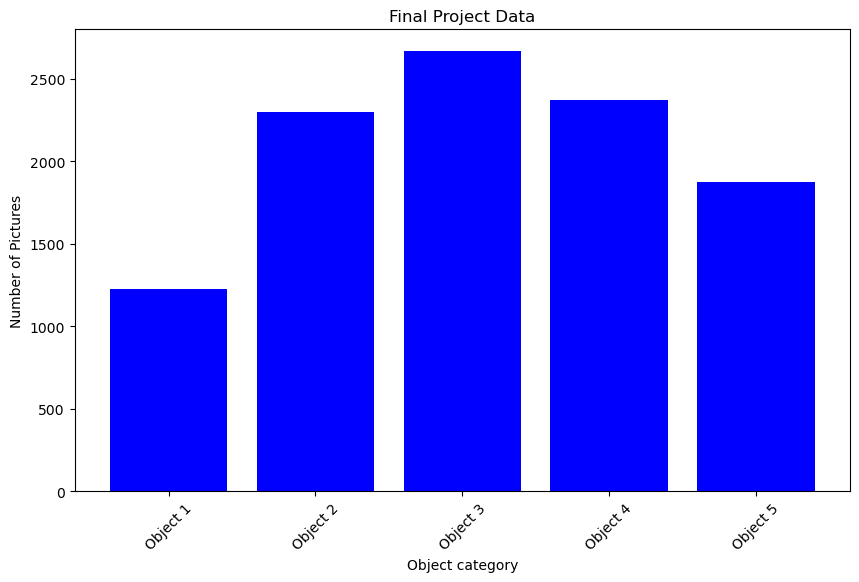

In [29]:
#objects= list(data)
#num_pictures=list(data.quantities())
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(object, num_items, color='blue')
plt.xlabel('Object category')
plt.ylabel('Number of Pictures')
plt.title('Final Project Data')
plt.xticks(rotation=45)
plt.show()

In [30]:
data.head()

,data,quantity
0,data/metadata/100313.json,1
1,data/metadata/09915.json,1
2,data/metadata/103299.json,1
3,data/metadata/00710.json,1
4,data/metadata/05397.json,1


In [34]:
data["quantity"] = pd.to_numeric(data["quantity"])
print(data)

                            data  quantity
0      data/metadata/100313.json         1
1       data/metadata/09915.json         1
2      data/metadata/103299.json         1
3       data/metadata/00710.json         1
4       data/metadata/05397.json         1
...                          ...       ...
10436  data/metadata/100598.json         5
10437    data/metadata/1042.json         5
10438   data/metadata/07628.json         5
10439  data/metadata/103667.json         5
10440  data/metadata/104002.json         5

[10441 rows x 2 columns]


In [40]:
final_project=  'final_project'

In [41]:
main_dirs = os.listdir(final_project)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(final_project, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'Number of images are {num_items[directory]} images with {directory} items in it.')

Number of images are 1228 images with 1 items in it.
Number of images are 2299 images with 2 items in it.
Number of images are 2666 images with 3 items in it.
Number of images are 2373 images with 4 items in it.
Number of images are 1875 images with 5 items in it.


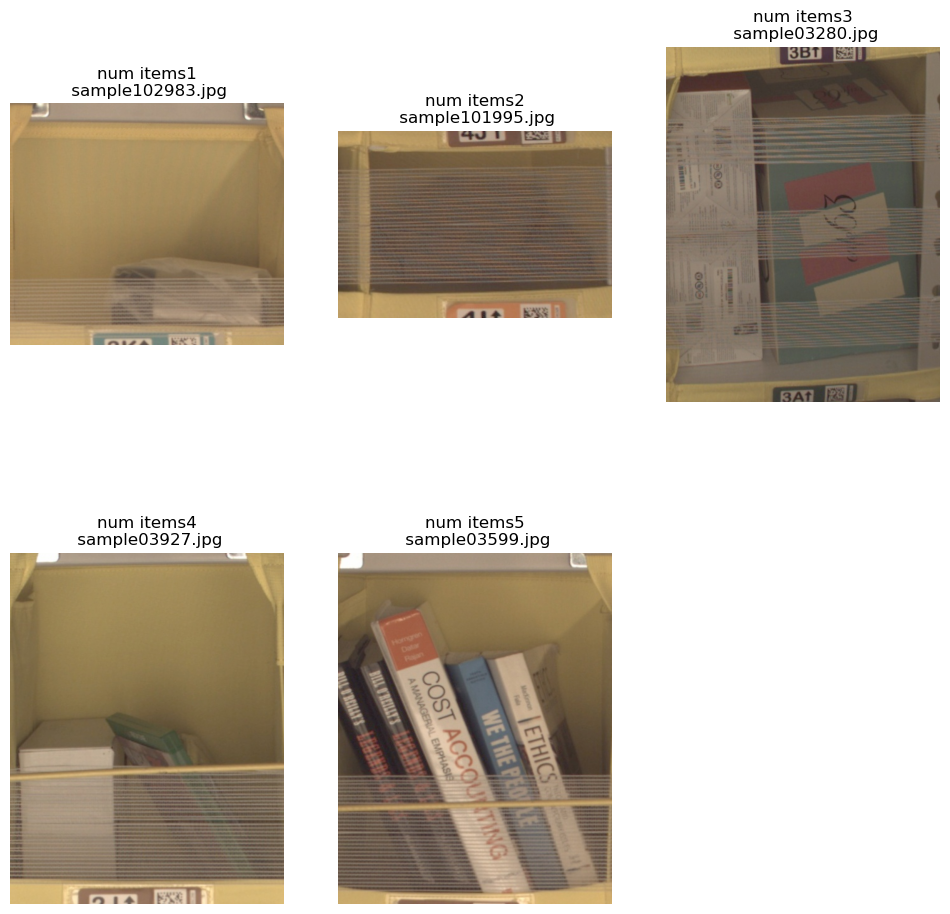

In [42]:
# Plot some of the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(final_project, key, img_filename)).squeeze(), cmap="gray")
plt.show()

In [38]:
#TODO: Upload the data to AWS S3

In [44]:
file_list_train = {}
file_list_test = {}
file_list_valid = {}
for key in num_items.keys():
    test_no = int(0.2*num_items[key])
    #remaining_no=num_items[key] - test_no
    #train_no =  int(num_items[key] - test_no)
    #train_no =  int(0.6 * remaining_no)
    test_no = int(0.6*num_items[key])
    valid_no = int(0.2*num_items[key])
    file_list_test[key] = []
    file_list_train[key] = []
    file_list_valid[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if (idx<(test_no)):
            file_list_test[key].append(filename)
        elif idx<(test_no + train_no):
            file_list_train[key].append(filename)
        else:
            file_list_valid[key].append(filename)
            
    print(f'num items {key}: Test: {test_no}, Train: {train_no}, Valid: {valid_no}')

num items 1: Test: 736, Train: 1200, Valid: 245
num items 2: Test: 1379, Train: 1200, Valid: 459
num items 3: Test: 1599, Train: 1200, Valid: 533
num items 4: Test: 1423, Train: 1200, Valid: 474
num items 5: Test: 1125, Train: 1200, Valid: 375


In [44]:
file_list_train = {}
file_list_test = {}
file_list_valid = {}
for key in num_items.keys():
    test_no = int(0.2*num_items[key])
    #remaining_no=num_items[key] - test_no
    #train_no =  int(num_items[key] - test_no)
    #train_no =  int(0.6 * remaining_no)
    test_no = int(0.6*num_items[key])
    valid_no = int(0.2*num_items[key])
    file_list_test[key] = []
    file_list_train[key] = []
    file_list_valid[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if (idx<(test_no)):
            file_list_test[key].append(filename)
        elif idx<(test_no + train_no):
            file_list_train[key].append(filename)
        else:
            file_list_valid[key].append(filename)
            
    print(f'num items {key}: Test: {test_no}, Train: {train_no}, Valid: {valid_no}')

num items 1: Test: 736, Train: 1200, Valid: 245
num items 2: Test: 1379, Train: 1200, Valid: 459
num items 3: Test: 1599, Train: 1200, Valid: 533
num items 4: Test: 1423, Train: 1200, Valid: 474
num items 5: Test: 1125, Train: 1200, Valid: 375


In [48]:
project1= 'project1'
os.mkdir(project1)
os.mkdir(os.path.join(project1, 'train'))
os.mkdir(os.path.join(project1, 'test'))
os.mkdir(os.path.join(project1, 'valid'))

In [49]:
for key in num_items.keys():
    os.mkdir(os.path.join(project1, 'test', key))
    os.mkdir(os.path.join(project1, 'train', key))
    os.mkdir(os.path.join(project1, 'valid', key))

In [50]:
import shutil
for key in num_items.keys():    
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(final_project, key, filename), os.path.join(project,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(final_project, key, filename), os.path.join(project,'train', key, filename))
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(final_project, key, filename), os.path.join(project,'valid', key, filename))
print("Finished")

Finished


In [ ]:

!aws s3 cp project s3://sagemaker-us-east-1-605100438424/project1 --recursive

upload: project/test/1/00035.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00035.jpg
upload: project/test/1/00100.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00100.jpg
upload: project/test/1/00148.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00148.jpg
upload: project/test/1/00084.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00084.jpg
upload: project/test/1/00048.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00048.jpg
upload: project/test/1/00024.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00024.jpg
upload: project/test/1/00086.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00086.jpg
upload: project/test/1/00194.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00194.jpg
upload: project/test/1/00014.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00014.jpg
upload: project/test/1/00213.jpg to s3://sagemaker-us-east-1-605100438424/project1/test/1/00213.jpg


## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [56]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values


hyperparameter_ranges = {
    "learning_rate": 0.005,
    "batch_size": 64,
    "epochs": 5,
}



In [57]:
#TODO: Create your training estimator

In [58]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    source_dir=".",
    instance_type="ml.m5.xlarge",
    py_version='py3',
    hyperparameter_ranges=hyperparameter_ranges
)


In [60]:
# TODO: Fit your estimator
estimator.fit(
    {
        "training": "s3://sagemaker-us-east-1-605100438424/project1/train", 
        "test": "s3://sagemaker-us-east-1-605100438424/project1/test",
        "valid": "s3://sagemaker-us-east-1-605100438424/project1/valid"
    }, 
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-11-04-19-10-35-162


2024-11-04 19:16:45 Starting - Starting the training job...
2024-11-04 19:17:02 Starting - Preparing the instances for training...
2024-11-04 19:17:33 Downloading - Downloading input data......
2024-11-04 19:18:18 Downloading - Downloading the training image...
2024-11-04 19:19:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-04 19:19:08,885 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-04 19:19:08,889 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-11-04 19:19:08,900 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-04 19:19:08,903 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-11-04 19:19:40,586 sagemaker-containers INFO     Module default_user_module_name does not provide a setu

UnexpectedStatusException: Error for Training job pytorch-training-2024-11-04-19-10-35-162: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_training/trainer.py", line 85, in train
    entrypoint()
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_pytorch_container/training.py", line 99, in main
    train(framework.training_env())
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_pytorch_container/training.py", line 60, in train
    six.reraise(info[0], err, info[2])
  File "/opt/conda/lib/python3.6/site-packages/six.py", line 703, in reraise
    raise value
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_pytorch_container/training.py", line 53, in train
    capture_error=True, runner=framework.runner.ProcessRunnerType)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_containers/entry_point.py", line 100, in run
    wait, capture_error
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_containers/_process.py", line 112, in run
    cmd, _errors.ExecuteUserScriptError, capture_error=captur

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [108]:
#TODO: Create your hyperparameter search space

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    
}





In [109]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [110]:
#TODO: Create your training estimator
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

In [111]:
train = "s3://sagemaker-us-east-1-605100438424/project1/train" 
test = "s3://sagemaker-us-east-1-605100438424/project1/test"
valid = "s3://sagemaker-us-east-1-605100438424/project1/valid"

In [112]:
tuner.fit(
    {
        "training": train, 
        "valid": valid,
        "test": test,
    }, 
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-241104-2120


............................................................*


UnexpectedStatusException: Error for HyperParameterTuning job pytorch-training-241104-2120: Failed. Reason: All training jobs failed. Please take a look at the training jobs failures to get more details.

In [ ]:
# TODO: Find the best hyperparameters
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [90]:
import smdebug.pytorch as smd
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

In [91]:
# TODO: Create and fit an estimator
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [92]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Next we will specify the hyperparameters and create our estimator. In our estimator, we will additionally need to specify the debugger rules and configs that we created before.

In [93]:
hyperparameters = {"epochs": "2", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"}

In [94]:
estimator = PyTorch(
    entry_point="pytorch_mnist.py",
    base_job_name="smdebugger-mnist-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

In [95]:
estimator.fit(wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-mnist-p

2024-11-04 20:24:03 Starting - Starting the training job...
2024-11-04 20:24:34 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-11-04 20:24:54 Downloading - Downloading input data...
2024-11-04 20:25:34 Downloading - Downloading the training image......
2024-11-04 20:26:35 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-04 20:26:29,816 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-04 20:26:29,819 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-04 20:26:29,828 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-04 20:26:29,831 sagemaker_pytorch_container.training INF

In [96]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'smdebugger-mnist-pytorch-2024-11-04-20-24-00-304',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:605100438424:training-job/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '"32"',
  'epochs': '"2"',
  'lr': '"0.001"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"smdebugger-mnist-pytorch-2024-11-04-20-24-00-304"',
  'sagemaker_program': '"pytorch_mnist.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/source/sourcedir.tar.gz"',
  'test-batch-size': '"100"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-cpu-py36',


In [97]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [98]:
# TODO: Display the profiler output
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

! aws s3 ls {rule_output_path} --recursive


2024-11-04 20:30:38     329700 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-04 20:30:37     171060 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-04 20:30:33        191 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-04 20:30:33        199 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-04 20:30:33        126 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-04 20:30:33        127 smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-11-04 20:30:33        198 smdebugger-mnist-pytorch-2024-11-04-20-24-00-30

In [99]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-605100438424/smdebugger-mnist-pytorch-2024-11-04-20-24-00-304/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.j

In [100]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [101]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [102]:
# TODO: Deploy your model to an endpoint
model_location=estimator.model_data

In [103]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


In [104]:


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

NameError: name 'Predictor' is not defined

In [ ]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [106]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

NameError: name 'pytorch_model' is not defined

In [ ]:
response = predictor.predict()

In [ ]:
# TODO:Querying your model
import gzip 
import numpy as np
import random
import os

data_dir = 'project1/test'
with gzip.open(os.path.join(data_dir, "test_image.jpg"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16) # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

In [ ]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

In [ ]:
#Model Evaluation
rsme = {}

for i in range(1, 6):
    rsme[i] = sum(list(map(lambda x: (x - i) ** 2, model_responses[i])))
    print(f"RSME for {i} objects: {math.sqrt(rsme[i]/200)}")

print(f"Total RSME: {math.sqrt(sum(rsme.values())/1000)}")

In [107]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
tuner.delete_endpoint()

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis
model_responses = defaultdict(lambda: list())

for i in range(1, 6):
    path = f"nd009t-capstone-starter/starter/project1/test/{i}/"
    for f in listdir(path):
        file_path = f"{path}{f}"
        model_responses[i].append(identify_num_objects(file_path))

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances
containers = {
              'us-east-1': 's3://sagemaker-us-east-1-605100438424/project1/'
              }
container = containers[boto3.Session().region_name]

In [ ]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [ ]:
sharded_job = 'project/test' 

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

In [ ]:
#sm.create_training_job(**sharded_training_params)

sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=replicated_job)
status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=replicated_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')
    

In [ ]:
#print('Sharded:', sm.describe_training_job(TrainingJobName=sharded_job)['TrainingJobStatus'])
print('Replicated:', sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus'])